In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv("../input/netflix-shows/netflix_titles.csv")

In [ ]:
df.head(3)

# Thank you for reading and an upvote will be really appreciated.

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title = "Netflix Report", explorative=False)
profile.set_variable("correlations", None)
profile.set_variable("interactions", None)
profile.set_variable("samples", None)
profile

What can two lines code tell us? 

There are 7787 records, among which 69% are movies and the rest are shows. 

33% of the shows/movies are from the US, 11.9% from India and 5.1% from the UK. 

Intuitively this dataset does not reflects the population really well. 

We have the histogram of year distribution. 

Most of the shows are 1 season. 

director has 2389 (30.7%) missing values

cast has 718 (9.2%) missing values

country has 507 (6.5%) missing values

Certainly this cannot be the report we want to submit to our manager. 
Now let us figure out how to make the charts PowerPoint level. 

### Movies and Shows distributions among years

In [ ]:
import plotly.express as px
fig = px.pie(df, names=df["type"], width=600, height=400)
fig.show()

In [ ]:
#Number of TV shows and Movies along the years. 
df_type = df.groupby(by=["release_year","type"], as_index=False).count()
df_type = df_type[["release_year","type","show_id"]]
df_type = df_type.loc[df_type["release_year"]>=1950]
df_type.rename(columns={"show_id":"count"},inplace=True)

fig = px.line(df_type, x="release_year",y="count",color="type",\
             width=800, height=600)
fig.show()
# We can basically tell the data from 2019 and 2020 cannot cover the population. 

### Rating Distribution

Movie Rating System
https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system

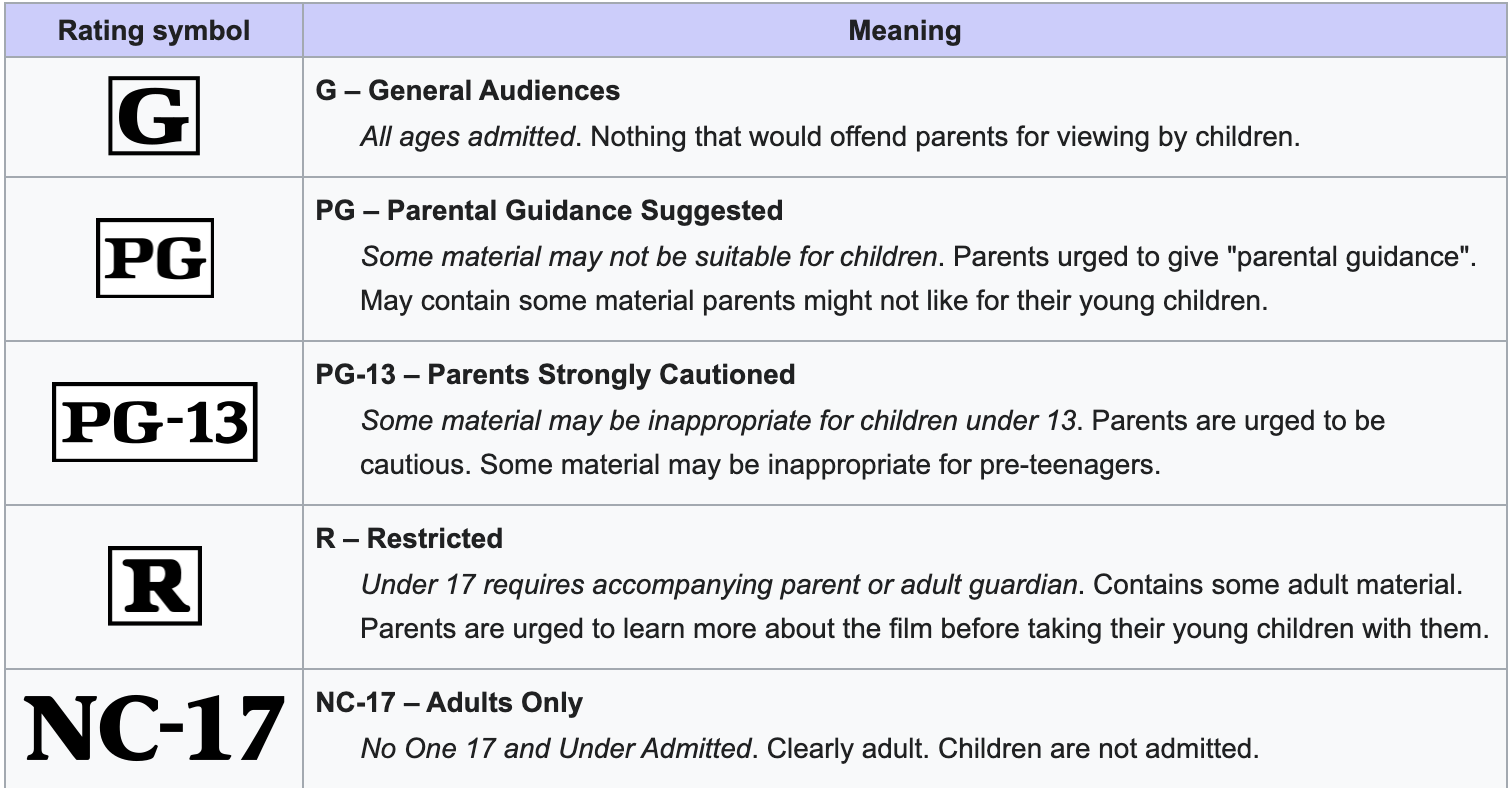

In [ ]:
fig = px.histogram(df, x="rating",color="type")
fig.show()

### Country Distribution

I think the country columns is not standardized country code format, which leads to a not accurate color bar. Further country code match can happen with third party dataset. The interactive labels are accurate in the map. 

In [ ]:
import plotly.graph_objects as go
df_country = df.groupby("country",as_index=False).count()
df_country = df_country[["country","show_id"]]
df_country.rename(columns={"show_id":"count"},inplace=True)

fig = go.Figure(data=go.Choropleth(
    locationmode = "country names",
    locations = df_country['country'],
    z = df_country['count'],
    colorscale="Jet",
    reversescale=False,
    zmin=0, zmax=10,
    colorbar_title = 'Number of Movies and Shows',
))

fig.update_layout(
    title_text='Number of Movies and Shows',
    geo=dict(
        showcoastlines=True,
    ),
)

fig.show()

In [ ]:
df_country = df_country[df_country["count"]>=50]
fig = px.bar(df_country, x="country", y="count")
fig.update_xaxes(categoryorder="total descending")
fig.show()

The top four countries are United States, India, United Kingdom, and South Korea. We might want to see the growth rates of movies and shows in these countries in the last a few years. 

In [ ]:
df_country = df.groupby(["country","type","release_year"],as_index=False).count()
countries = ["United States", "India", "United Kingdom", "South Korea"]
df_country = df_country[df_country["country"].isin(countries)]
df_country = df_country[["country","type","release_year","show_id"]]
df_country = df_country[df_country["release_year"]>2005]
df_country.rename(columns={"show_id":"count"}, inplace=True)

fig_movie = px.line(df_country,x="release_year",y="count",color="country",\
                    facet_col="type", width=800,height=600)
fig_movie.show()

### TV Shows and Movies Distribution

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df_movie = df[df["type"]=="Movie"]
df_show = df[df["type"]=="TV Show"]

df_movie["duration"] = df_movie["duration"].str.replace("min","")
df_movie["duration"] = df_movie["duration"].astype("int")
fig = px.histogram(df_movie,x="duration",labels={"duration":"Movies Duration (in minutes)"},\
                  width=600, height=300,template="plotly_white")
fig.update_xaxes(categoryorder="category ascending")
fig.update_layout(margin=dict(t=0,b=0))
fig.show()

df_show["duration"] = df_show["duration"].str.replace(" Seasons","")
df_show["duration"] = df_show["duration"].str.replace(" Season","")
df_show["duration"] = df_show["duration"].astype("int")
fig = px.histogram(df_show,x="duration",labels={"duration":"Shows Duration(Seasons)"},\
                  width=600, height=300,template="plotly_white")
fig.update_xaxes(categoryorder="category ascending")
fig.update_layout(margin=dict(t=0,b=0))
fig.show()

### Director and Cast

In [ ]:
# Most productive director
df_director = df.groupby(["director","country"],as_index=False).count()
df_director.sort_values("show_id", ascending=False).head(5)

#The most productive director is Marcus Raboy from the United States.

In [ ]:
df["cast"] = df["cast"].astype(str)
df["num_cast"] = df["cast"].apply(lambda x: x.count(",")+1)
df = df[df["num_cast"]!=0]
df[df["num_cast"]==df["num_cast"].max()]
# The Black Mirror and Social Distance have the most cast number, which is 50. 

In [ ]:
fig = px.histogram(df, x = df["num_cast"], color="type",template="plotly_white",\
                  width=600, height=400 )
fig.show()

Here is a "tricky" job: We want to find the actor who were in most shows/movies. 
To do this, we have to manipulate the string format cells and the entire dataframe with other types like dictionary, set or list. 

In [ ]:
# When we convert a column/series of strings into a list, we will get a list of strings. 
# All the elements are mixed in a single string. 
# We can write a function to separate all the elements and combine them into a list. 
# This function can be applied to several columns in this datset. 

def list_expand(l):
    return_list = []
    for element in l:
        for genre in element.split(","):
            return_list.append(genre)
    return return_list

# After we get the list, we can write a function to count all the elements in the list.

def create_dict_from_list_count(d, l):
    for key in d.keys():
        d[key] = l.count(key)
    return d
        

cast_total_list = df["cast"].tolist()
cast_list = list_expand(cast_total_list)
cast_set = set(cast_list)
print("there are totally {} actors".format(len(cast_set)))

cast_dict = dict.fromkeys(cast_set, 0)
cast_dict = create_dict_from_list_count(cast_dict,cast_list)
cast_dict.pop('nan', None)

productive_actor = max(cast_dict, key=cast_dict.get)
print("The most productive actor is {}, He/She was in {} Shows/Movies".\
     format(productive_actor, cast_dict.get(productive_actor)))

In [ ]:
movie_type = df_movie["listed_in"].tolist()
show_type = df_show["listed_in"].tolist()


movie_gene_list = list_expand(movie_type)
show_gene_list = list_expand(show_type)

movie_gene_set = set(movie_gene_list)
show_gene_set = set(show_gene_list)

print("there are totally {} genres in the movie sector".format(len(movie_gene_set)))
print("there are totally {} genres in the show sector".format(len(show_gene_set)))

movie_dict = dict.fromkeys(movie_gene_set, 0)
show_dict = dict.fromkeys(show_gene_set, 0)

movie_dict = create_dict_from_list_count(movie_dict, movie_gene_list)
show_dict = create_dict_from_list_count(show_dict, show_gene_list)

In [ ]:
movie_gene_count_df = pd.DataFrame.from_dict(movie_dict, orient="index",columns=["count"])
movie_gene_count_df.reset_index(inplace=True)
movie_gene_count_df.rename(columns={"index":"movie_genre"}, inplace=True)

show_gene_count_df = pd.DataFrame.from_dict(show_dict, orient="index",columns=["count"])
show_gene_count_df.reset_index(inplace=True)
show_gene_count_df.rename(columns={"index":"show_genre"}, inplace=True)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                   subplot_titles=("Movie Genre Distribution","Show Genre Distribution"))

fig.add_trace(go.Bar(x=movie_gene_count_df["movie_genre"], y=movie_gene_count_df["count"],
                    marker=dict(coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=show_gene_count_df["show_genre"], y=show_gene_count_df["count"],
                    marker=dict(coloraxis="coloraxis")),
              1, 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False, title_text="Genre Distribution")

fig.update_xaxes(categoryorder="total descending")

fig.show()

### Word Maps of Descriptions

In [ ]:
import nltk
from wordcloud import WordCloud
nltk.download('stopwords')


movie_description = "".join(str(x) for x in df_movie["description"])
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(movie_description)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
show_description = "".join(str(x) for x in df_show["description"])
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(show_description)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Generally both movies and shows are realted with families and friends. They have different emphasis on topics. 

# Thank you for reading and an upvote will be really appreciated.